In [8]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

In [9]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [11]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [12]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [13]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Precipitation Analysis

In [16]:
inspector = inspect(engine)

In [17]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [18]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(f"The date one year from the last date in data set is {one_year_ago}")

The date one year from the last date in data set is 2016-08-23


In [20]:
# Perform a query to retrieve the data and precipitation scores
data_precip_scores = session.query(Measurement.date, Measurement.prcp).all()

for data_precip_score in data_precip_scores[:10]:
    print(f"Date: {data_precip_score.date}, Precipitation: {data_precip_score.prcp}")

Date: 2010-01-01, Precipitation: 0.08
Date: 2010-01-02, Precipitation: 0.0
Date: 2010-01-03, Precipitation: 0.0
Date: 2010-01-04, Precipitation: 0.0
Date: 2010-01-06, Precipitation: None
Date: 2010-01-07, Precipitation: 0.06
Date: 2010-01-08, Precipitation: 0.0
Date: 2010-01-09, Precipitation: 0.0
Date: 2010-01-10, Precipitation: 0.0
Date: 2010-01-11, Precipitation: 0.01


In [21]:

# Save the query results as a Pandas DataFrame. Explicitly set the column names
date_and_rain = pd.DataFrame(data_precip_scores, columns=['Date', 'Precipitation'])
date_and_rain.head()

,Date,Precipitation
0,2010-01-01,0.08
1,2010-01-02,0.00
2,2010-01-03,0.00
3,2010-01-04,0.00
4,2010-01-06,NaN


In [22]:

# Sort the dataframe by date
date_and_rain_sorted = date_and_rain.sort_values(by="Date")
date_and_rain_sorted.set_index('Date', inplace=True)
date_and_rain_sorted.head()

,Precipitation
Date,
2010-01-01,0.08
2010-01-01,0.21
2010-01-01,0.15
2010-01-01,0.15
2010-01-01,0.05


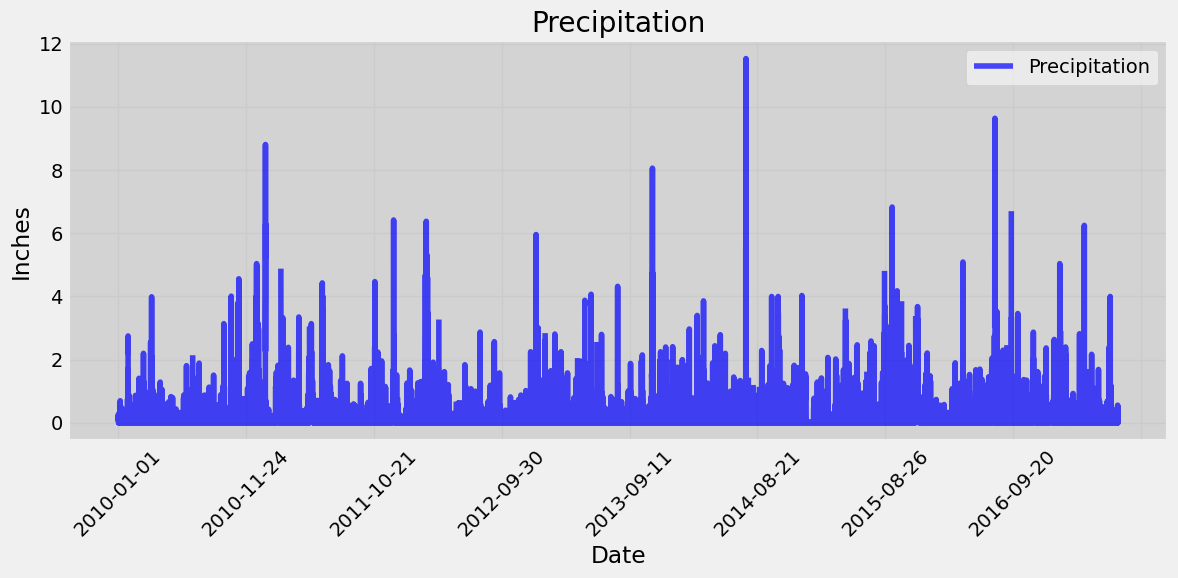

In [23]:
# Use Pandas Plotting with Matplotlib to plot the data
# Plotting using Pandas plotting with Matplotlib

fig, ax = plt.subplots(figsize=(12, 6))

date_and_rain_sorted.plot(kind='line', color='b', alpha=0.7, legend=True, ax=ax) # Create a line plot

plt.title('Precipitation')  # Set the title of the plot
plt.xlabel('Date')  # Set the label for the x-axis
plt.ylabel('Inches')  # Set the label for the y-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Add gridlines to the plot
ax.set_facecolor('lightgray') #Add background color
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig("Resources/precipitation.png")
plt.show()  # Display the plot

In [24]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = date_and_rain['Precipitation'].describe()

summary_df = pd.DataFrame(summary_statistics)

summary_df

,Precipitation
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


# Exploratory Station Analysis

In [25]:
# Design a query to calculate the total number of stations in the dataset
n_stations = session.query(Measurement.station).distinct().count()

n_stations


9

In [26]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

print("Most Active Stations (Station ID, Number of Observations):")
for station, count in most_active_stations:
    print(station, count)

Most Active Stations (Station ID, Number of Observations):
USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [27]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'

temperature_stats = session.query(func.min(Measurement.tobs), 
                                 func.max(Measurement.tobs), 
                                 func.avg(Measurement.tobs)).\
                    filter(Measurement.station == most_active_station_id).all()

if temperature_stats:
    min_temp, max_temp, avg_temp = temperature_stats[0]
    print(f"Most Active Station ID: {most_active_station_id}")
    print(f"Lowest Temperature: {min_temp}°F")
    print(f"Highest Temperature: {max_temp}°F")
    print(f"Average Temperature: {avg_temp:.2f}°F")
else:
    print(f"No temperature data available for station ID: {most_active_station_id}")

Most Active Station ID: USC00519281
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


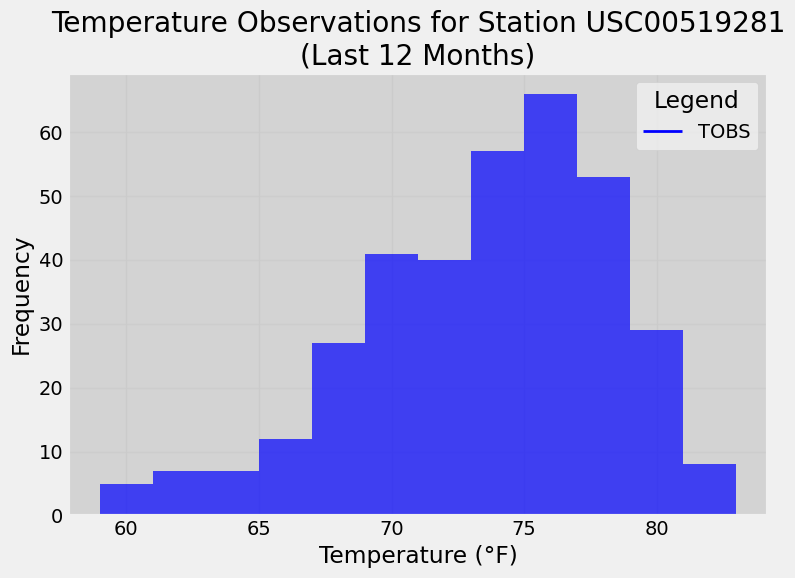

In [28]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()

# Convert the TOBS data to a list
tobs_list = [result[0] for result in tobs_data]

# Plotting the histogram using Matplotlib
plt.figure(figsize=(8, 6))
ax = plt.gca()  # Get the current axes
ax.set_facecolor('lightgray')
plt.hist(tobs_list, bins=12, color='blue', alpha=0.7)
plt.title(f'Temperature Observations for Station {most_active_station_id}\n(Last 12 Months)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
# Create a custom legend handle with a blue line and the label "TOBS"
legend_elements = [Line2D([0], [0], color='blue', lw=2, label='TOBS')]

# Add legend with custom handle
plt.legend(handles=legend_elements, loc='upper right', fontsize='medium', title='Legend', title_fontsize='large')
plt.savefig('Resources/tobs.png')
# Display the plot
plt.show()

# Close Session

In [29]:
# Close Session
session.close()